## Generating Data for Ground Truth Evaluation

In order to generate a ground truth summary for our data, we first need an input dataset. In this case we use threads from the [Thunderbird public mailing list.](https://thunderbird.topicbox.com/latest).  In order to generate the ground truth and then later evaluate the model, we need at least 100 samples to start with, where a sample is a single email or single email conversation.

Our selection criteria: 

+ Collect 100 samples of email thread conversations, as recent as possible and fairly complete so they can be evaluated
+ Clean them of email formatting such as `>`
+ One consideration here will be that BART, the baseline model we're using, accepts 1024 token context window as input, i.e.  we have to have input email threads that are ~ approximately 1000 words, so keeping on the conservative side

Once we've collected them, we'd like to take a look at the data before we generate summaries. 

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# wrap columns for inspection
pd.set_option('display.max_colwidth', 0)
# stylesheet for visibility
plt.style.use("fast")

In [6]:
# load into pandas
df = pd.read_csv('thunderbird_samples.csv')

In [9]:
# Examine a single sample 
df['example'].iloc[0]

'I recently added a beta release, version 7.0b1, of my extension, Clippings for Thunderbird, and selected the option to self-host it so that I can make it available to testers separately while regular users continue to see version 6.3.5, the current release version. However, the beta release is now incorrectly appearing in the Add-ons for Thunderbird public listing. URL to ATN listing: https://addons.thunderbird.net/en-US/thunderbird/addon/clippings-tb/. Thanks for the report, it is best to file an issue with the addons-server: https://github.com/thunderbird/addons-server I have not looked at it in detail, but self-hosted add-ons need an update_url entry in their manifest and that should prevent it from being accepted on ATN. Since we do not sign add-ons, self-hosted add-ons do not need to be submitted to ATN at all.My best-practice advice is:\n- remove the beta version from ATN,\n- create a dedicated branch/repo which holds the update information (either a branch in each add-on repo y

In [10]:
# Add a function to do some simple character counts for model input

df['char_count'] = df['example'].str.len()

In [12]:
df.head()

,example,char_count
0,"I recently added a beta release, version 7.0b1, of my extension, Clippings for Thunderbird, and selected the option to self-host it so that I can make it available to testers separately while regular users continue to see version 6.3.5, the current release version. However, the beta release is now incorrectly appearing in the Add-ons for Thunderbird public listing. URL to ATN listing: https://addons.thunderbird.net/en-US/thunderbird/addon/clippings-tb/. Thanks for the report, it is best to file an issue with the addons-server: https://github.com/thunderbird/addons-server I have not looked at it in detail, but self-hosted add-ons need an update_url entry in their manifest and that should prevent it from being accepted on ATN. Since we do not sign add-ons, self-hosted add-ons do not need to be submitted to ATN at all.My best-practice advice is:\n- remove the beta version from ATN,\n- create a dedicated branch/repo which holds the update information (either a branch in each add-on repo you want to self-host, or a single update-repo with the information for all your add-ons)\n- host the XPI files either as an ""beta"" asset in a ""github release"", or directly as a file in the repo (I think the asset is the better choice),\n- make sure that the manifest of your self-hosted XPI points to the correct update.json. John I've removed the beta version of my extension from ATN, and the listing for my extension now shows the current stable release. Thanks for your help!",1474
1,"the Thunderbird team is preparing the next big release: Thunderbird 128 ESR. Now is a good time to check if your add-ons are compatible. Thunderbird 128 is currently being shipped through the beta release channel. If you have not already installed Thunderbird Beta, you can get it from Thunderbird's download page [1]: Select the desired language, your operating system, and switch the ""release channel"" selection to ""Beta"".\n\nA list of known required changes to make add-ons compatible with Thunderbird 128 can be found on developer.thunderbird.net [2]. These changes mostly affect Experiment add-ons, which directly interact with Thunderbird code. WebExtensions usually do not need updates, but the add-ons team had to introduce the messagesUpdate permission, and browser.messages.update() will stop working, if the new permission has not been requested.\nAnother notably change is the official support of Manifest Version 3 in Thunderbird 128. The add-ons team removed deprecated elements and made additional changes to resolve inconsistencies in the APIs. The full list of changes can be found on webextension-api.thunderbird.net [3].\n\nStarting with Thunderbird 128, the API documentation on webextension-api.thunderbird.net [4] not only includes the WebExtension APIs added by Thunderbird, but also those inherited from Firefox (Thunderbird and Firefox share a significant amount of code). We are listing only methods, which are actually supported and working.\n\nDo not hesitate to reach out for help [5]. Looking forward to see your add-ons running in Thunderbird 128!\n\nJohn\n\n\n[1] : https://www.thunderbird.net/thunderbird/all/\n[2] : https://developer.thunderbird.net/add-ons/updating/tb128\n[3] : https://webextension-api.thunderbird.net/en/128-esr-mv3/changes/esr128.html\n[4] : https://webextension-api.thunderbird.net/en/stable/\n[5] : https://developer.thunderbird.net/add-ons/community",1891
2,"Hi all, Well I think everything is in the title. We have an extension that shows pdf thumbs in the message pane (faster than openning them). We used to provide PDF.js. Is this still needed? Regards, We usually do not encourage add-ons to depend on files shipped with Thunderbird, because the file could be moved/renamed, which will break your add-on. Ship your own version, so your add-on always uses a known version and stays compatible, even if Thunderbird updates its internal file, which might include API changes which could break your add-on as well. John",5

In [13]:
df['char_count'].describe()

count    100.000000 
mean     1565.440000
std      1141.860305
min      120.000000 
25%      709.250000 
50%      1311.500000
75%      1969.500000
max      5427.000000
Name: char_count, dtype: float64

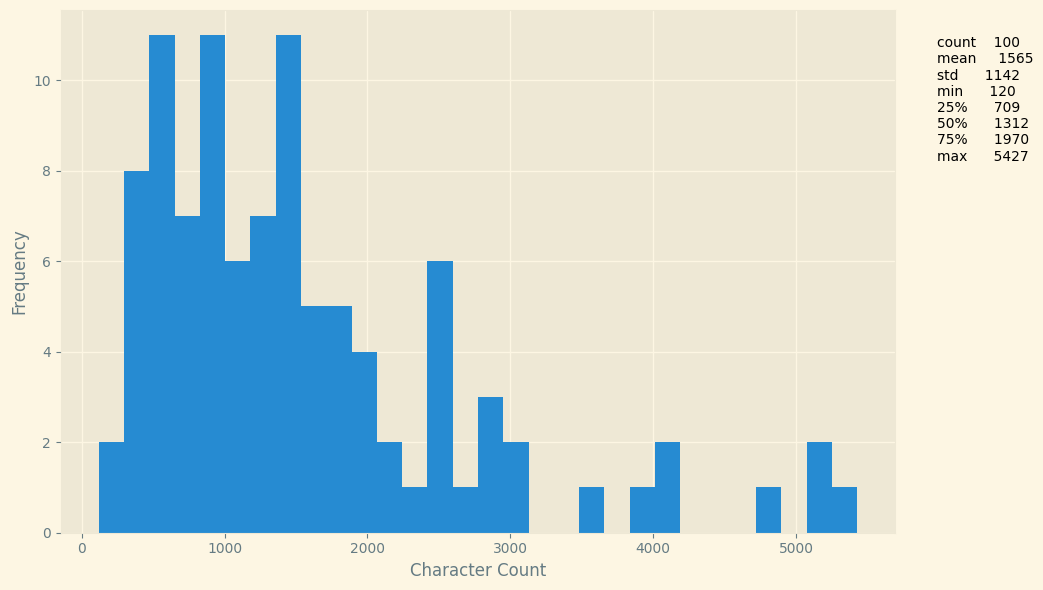

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(df['char_count'], bins=30)
ax.set_xlabel('Character Count')
ax.set_ylabel('Frequency')

stats = df['char_count'].describe().apply(lambda x: f"{x:.0f}")

# Add text boxes for statistics
plt.text(1.05, 0.95, stats.to_string(), 
         transform=ax.transAxes, verticalalignment='top')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.show()

We can see from the chart that about half of our email threads are on the shorter side, however 50% are more than 1300 characters which may be an issue for the model. Something to watch out for as we begin to run inference runs. If we wanted to be precise, we could tokenize each row with the [BART tokenizer](https://huggingface.co/docs/transformers/en/model_doc/bart#transformers.BartTokenizer)020 to get true counts input into the model.  